In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import os
import numpy as np
import warnings
from sklearn.cluster import DBSCAN

warnings.filterwarnings('ignore')


In [63]:
folder = "AB_2025"
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]
airbnbs = []
for file in csv_files:
    file_path = os.path.join(folder, file)
    df = pd.read_csv(file_path)
    airbnbs.append(df)

airbnbs_combined = pd.concat(airbnbs, ignore_index=True)
airbnbs_combined.to_csv("AB_2025_combined.csv", index=False)

/var/folders/7q/kdwv3c991lb35j5ylg3p275m0000gn/T/ipykernel_5397/3354674850.py:6: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/7q/kdwv3c991lb35j5ylg3p275m0000gn/T/ipykernel_5397/3354674850.py:6: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/7q/kdwv3c991lb35j5ylg3p275m0000gn/T/ipykernel_5397/3354674850.py:6: DtypeWarning: Columns (63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
/var/folders/7q/kdwv3c991lb35j5ylg3p275m0000gn/T/ipykernel_5397/3354674850.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the conc

In [100]:
airbnbs_df = pd.read_csv("AB_2025_combined.csv")
nghs = airbnbs_df.groupby("neighbourhood")

/var/folders/7q/kdwv3c991lb35j5ylg3p275m0000gn/T/ipykernel_5397/388116178.py:1: DtypeWarning: Columns (4,28,29,68,79,81,82,84,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnbs_df = pd.read_csv("AB_2025_combined.csv")


In [ ]:
ngh_count = nghs.count()["id"]
accepted_nghs = ngh_count[ngh_count > 100]

print("Amount of unique neighbourhoods:", len(nghs))
print("Average number of datapoints per possible node:", round(ngh_count.mean()))
print("Median number of datapoints per possible node:", ngh_count.median())
print("Number of neighbourhoods with >100 datapoints", len(accepted_nghs))


Amount of unique neighbourhoods: 23018
Average number of datapoints per possible node: 32
Median number of datapoints per possible node: 1.0
Number of neighbourhoods with >100 datapoints 425


In [ ]:

output_path = "AB_filtered_2025.csv"

if os.path.exists(output_path):
    print(f"File '{output_path}' already exists.")
    airbnbs_filtered = pd.read_csv(output_path)
    print("Loaded existing filtered data.")
    print("Number of filtered datapoints:", len(airbnbs_filtered))
else:
    airbnbs_filtered = airbnbs_df[airbnbs_df["neighbourhood"].isin(accepted_nghs.index)]
    airbnbs_filtered = airbnbs_filtered[airbnbs_filtered["neighbourhood"] != "Neighborhood highlights"]

    airbnbs_filtered.to_csv(output_path, index=False)
    print("Filtered data saved.")
    print("Number of filtered datapoints:", len(airbnbs_filtered))

File 'AB_filtered_2025.csv' already exists.
Loaded existing filtered data.
Number of filtered datapoints: 305068
                         id                                       listing_url  \
0                     52811                https://www.airbnb.com/rooms/52811   
1                    787045               https://www.airbnb.com/rooms/787045   
2                    795701               https://www.airbnb.com/rooms/795701   
3                    798444               https://www.airbnb.com/rooms/798444   
4                    798907               https://www.airbnb.com/rooms/798907   
...                     ...                                               ...   
305063  1370873693159068111  https://www.airbnb.com/rooms/1370873693159068111   
305064  1369403643191165714  https://www.airbnb.com/rooms/1369403643191165714   
305065  1369588785265198822  https://www.airbnb.com/rooms/1369588785265198822   
305066  1369590119821492935  https://www.airbnb.com/rooms/1369590119821492935

In [147]:
airbnbs_filtered["neighbourhood"].unique()

array(['Providencia, Región Metropolitana, Chile',
       'Santiago, Santiago Metropolitan Region, Chile',
       'Santiago, Región Metropolitana, Chile',
       'Las Condes, Región Metropolitana, Chile',
       'Recoleta, Región Metropolitana, Chile',
       'Vitacura, Región Metropolitana, Chile',
       'Ñuñoa, Región Metropolitana, Chile',
       'Lo Barnechea, Región Metropolitana, Chile',
       'Alberobello, Puglia, Italy, Italy',
       'Gallipoli, Puglia, Italy, Italy',
       'Monopoli, Puglia, Italy, Italy',
       'Martina Franca, Puglia, Italy, Italy',
       'Otranto, Puglia, Italy, Italy', 'Brindisi, Puglia, Italy, Italy',
       'Lecce, Puglia, Italy, Italy', 'Nardò, Puglia, Italy, Italy',
       'Marina di Mancaversa, Puglia, Italy, Italy',
       'Ostuni, Puglia, Italy, Italy',
       'Ceglie Messapica, Puglia, Italy, Italy',
       'Polignano A Mare, Puglia, Italy, Italy',
       'Polignano a Mare, Puglia, Italy, Italy', 'Ostuni, Apulia, Italy',
       'Bari, Puglia,

By observing the previous list, it is evident that grouping the dataset based on the neighbourhood-column does not work. This is because the neighbourhood-values can change by a very little depending on the location and the naming convention of the Airbnb host. For example, 'Polignano A Mare, Puglia, Italy, Italy' and 'Polignano a Mare, Puglia, Italy, Italy' differ by a single character, but they are actually the same location. Let's try to cluster the groups based on their latitude and longitude instead.

In [161]:
coords = np.radians(airbnbs_df[['latitude', 'longitude']])

# Define DBSCAN with haversine distance
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian  # 0.5 km neighborhood

db = DBSCAN(eps=epsilon, min_samples=100, algorithm='ball_tree', metric='haversine')
airbnbs_df['cluster'] = db.fit_predict(coords)


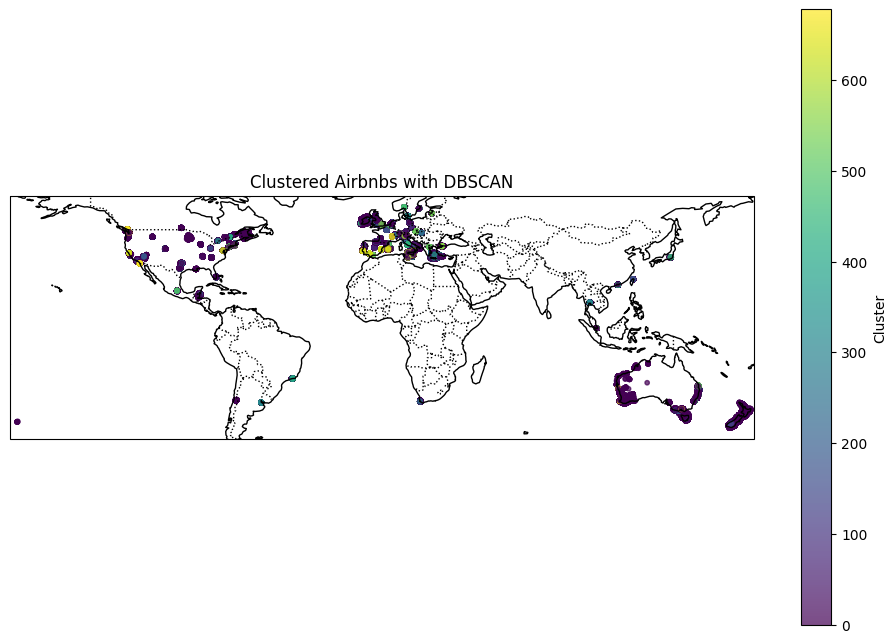

In [165]:
# Plotting the clusters on a map with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features to the map
ax.set_title("Clustered Airbnbs with DBSCAN")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

# Scatter the points, color them by cluster
scatter = ax.scatter(
    airbnbs_df['longitude'], airbnbs_df['latitude'], c=airbnbs_df['cluster'], 
    cmap='viridis', s=10, transform=ccrs.PlateCarree(), alpha=0.7
)

# Add a colorbar to indicate the cluster labels
plt.colorbar(scatter, ax=ax, label='Cluster')

# Show the plot
plt.show()


In [173]:
airbnbs_df = airbnbs_df[airbnbs_df["cluster"] != -1]
cluster_n = airbnbs_df["cluster"].unique()

cluster_counts = airbnbs_df.groupby('cluster').size()
average_datapoints_per_cluster = cluster_counts.mean()

print("Number of possible nodes:", max(cluster_n))
print("Number of datapoints in total:", len(airbnbs_df))
print(f"Average number of data points per cluster: {average_datapoints_per_cluster:.2f}")

Number of possible nodes: 678
Number of datapoints in total: 955007
Average number of data points per cluster: 1406.49
